# AutoInland Vehicle Insurance Claim



### Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm.notebook import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

### Read files

In [ ]:
# Load files into a pandas dataframe
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
ss = pd.read_csv('SampleSubmission.csv')

### Some basic EDA

In [ ]:
# Preview the first five rows of the train set
train.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0
4,ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1


In [ ]:
# Preview the first five rows of the test set
test.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,ID_01QM0NU,2010-10-23,2011-10-22,Female,46,2010-10-23,1,NaN,NaN,Ford,Abuja Municipal,Abuja-Municipal,Car Classic
1,ID_024NJLZ,2010-10-14,2011-10-13,Male,32,2010-10-14,1,NaN,NaN,NaN,Kosofe,Benue,Car Classic
2,ID_02NOVWQ,2010-08-29,2011-08-28,Female,45,2010-08-29,2,Saloon,Black,Honda,Wuse 11,Abuja,Car Classic
3,ID_02VSP68,2010-06-13,2011-06-12,Female,58,2010-06-13,1,Saloon,NaN,TOYOTA,NaN,NaN,CarSafe
4,ID_02YB37K,2010-07-01,2011-06-30,NaN,120,2010-07-01,1,Saloon,Red,Hyundai,Victoria Island,Lagos,Car Classic


In [ ]:
# Preview the first five rows of the sample submission file
ss.head()

,ID,target
0,ID_01QM0NU,0
1,ID_024NJLZ,0
2,ID_02NOVWQ,0
3,ID_02VSP68,0
4,ID_02YB37K,0


In [ ]:
# Check the shape of the train and test sets
print(f'The shape of the train set is: {train.shape}\nThe shape of the test set is: {test.shape}')

The shape of the train set is: (12079, 14)
The shape of the test set is: (1202, 13)


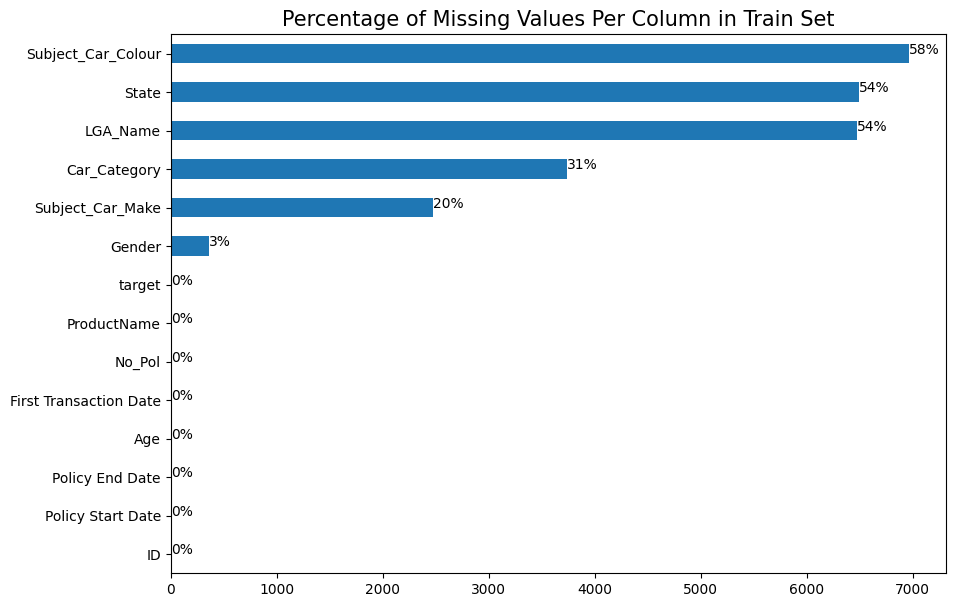

In [ ]:
# Check if there any missing values in train set
ax = train.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

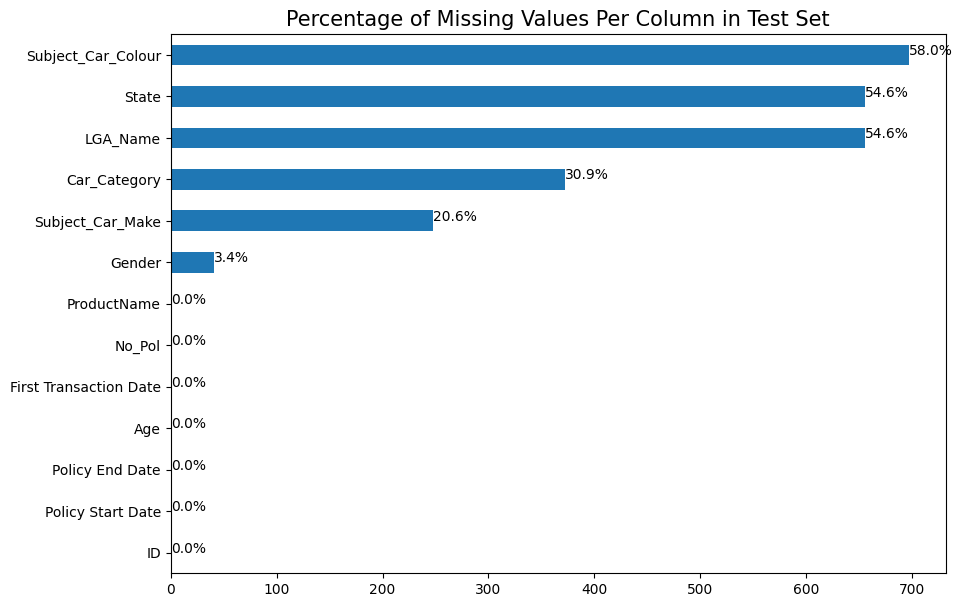

In [ ]:
# Check if there missing values in test set
ax = test.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Test Set', fontdict={'size':15})

for p in ax.patches:
    percentage ='{:,.1f}%'.format((p.get_width()/test.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

## Combine train and test set for easy preprocessing

In [ ]:
# Combine train and test set
ntrain = train.shape[0] # to be used to split train and test set from the combined dataframe

all_data = pd.concat((train, test)).reset_index(drop=True)
print(f'The shape of the combined dataframe is: {all_data.shape}')

The shape of the combined dataframe is: (13281, 14)


In [ ]:
# Preview the last five rows of the combined dataframe
all_data.tail()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
13276,ID_ZTTHC5X,2010-12-05,2011-12-04,Male,67,2010-12-05,2,JEEP,Black,TOYOTA,Victoria Island,Lagos,Car Classic,NaN
13277,ID_ZUJAFUP,2010-01-14,2011-01-13,Male,43,2010-01-14,1,Saloon,Silver,Hyundai,Surulere,Lagos,Car Classic,NaN
13278,ID_ZWHCTUM,2010-07-26,2011-07-25,Male,30,2010-07-26,1,Truck,White,Iveco,Victoria Island,Lagos,CVTP,NaN
13279,ID_ZWQRL8L,2010-02-16,2011-02-15,Male,44,2010-02-16,2,Saloon,NaN,Nissan,Aba North,Aba-North,Car Classic,NaN
13280,ID_ZWZ92GU,2010-03-18,2011-03-17,Male,28,2010-03-18,1,Saloon,Silver,TOYOTA,NaN,NaN,Car Classic,NaN


In [ ]:
# Check the column names and datatypes
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13281 entries, 0 to 13280
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      13281 non-null  object 
 1   Policy Start Date       13281 non-null  object 
 2   Policy End Date         13281 non-null  object 
 3   Gender                  12881 non-null  object 
 4   Age                     13281 non-null  int64  
 5   First Transaction Date  13281 non-null  object 
 6   No_Pol                  13281 non-null  int64  
 7   Car_Category            9171 non-null   object 
 8   Subject_Car_Colour      5622 non-null   object 
 9   Subject_Car_Make        10557 non-null  object 
 10  LGA_Name                6149 non-null   object 
 11  State                   6137 non-null   object 
 12  ProductName             13281 non-null  object 
 13  target                  12079 non-null  float64
dtypes: float64(1), int64(2), object(11)
me

In [ ]:
# Change each column to its appriopriate datatype
date_cols = [col for col in all_data.columns if 'Date' in col]
num_cols = ['Age', 'No_Pol']
cat_cols = [col for col in all_data.columns if col not in date_cols+num_cols+['ID', 'target']]

for col in all_data.columns:
  if col in date_cols:
    all_data[col] = pd.to_datetime(all_data[col])
  elif col in cat_cols:
    all_data[col] = all_data[col].astype('category')

# Confirm whether the changes have been applied successfully
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13281 entries, 0 to 13280
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID                      13281 non-null  object        
 1   Policy Start Date       13281 non-null  datetime64[ns]
 2   Policy End Date         13281 non-null  datetime64[ns]
 3   Gender                  12881 non-null  category      
 4   Age                     13281 non-null  int64         
 5   First Transaction Date  13281 non-null  datetime64[ns]
 6   No_Pol                  13281 non-null  int64         
 7   Car_Category            9171 non-null   category      
 8   Subject_Car_Colour      5622 non-null   category      
 9   Subject_Car_Make        10557 non-null  category      
 10  LGA_Name                6149 non-null   category      
 11  State                   6137 non-null   category      
 12  ProductName             13281 non-null  catego

### Distribution of the target variable

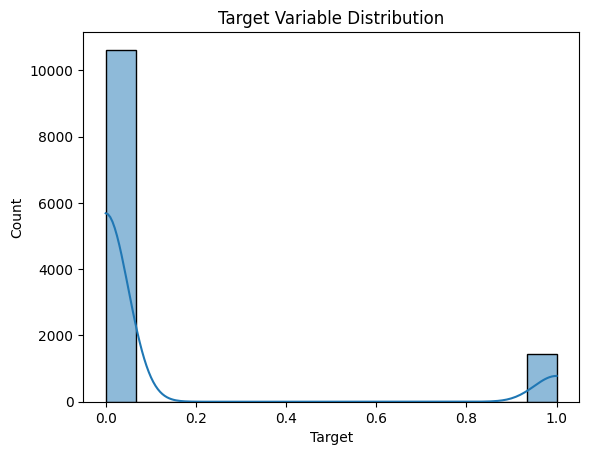

In [ ]:

sns.histplot(data=all_data, x='target', kde=True)
plt.title('Target Variable Distribution')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

### Distribution of the Gender column

In [ ]:
def plot_gender_distribution(data):
    ax_barh = data.Gender.value_counts().sort_values().plot(kind='barh', figsize=(10, 7))
    plt.title('Gender Distribution', fontdict={'size': 15})

    total_count = data.shape[0]
    for p in ax_barh.patches:
        width, height = p.get_width(), p.get_height()
        x = p.get_x() + width + 0.02
        y = p.get_y() + height / 2

        count = int(width)
        percentage = f'{(width / total_count) * 100:.1f}%'
        label = f'{count} ({percentage})'
        ax_barh.annotate(label, (x, y), fontsize=10)

    plt.xlabel('Count')
    plt.ylabel('Gender')
    plt.show()


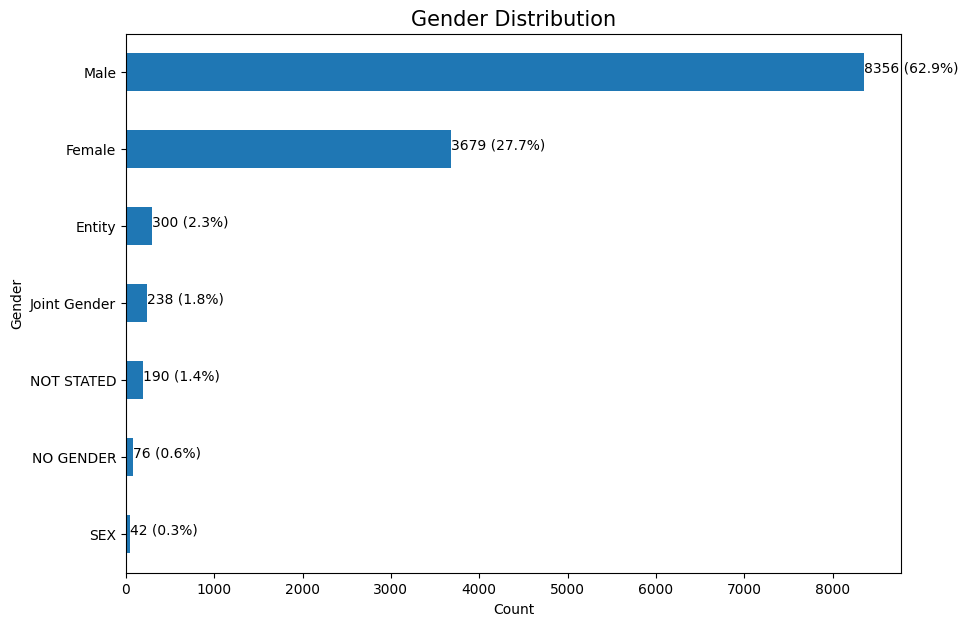

In [ ]:
plot_gender_distribution(all_data)


In [ ]:
mapper = {'Entity':'Other', 'Joint Gender':'Other', 'NOT STATED':'Other', 'NO GENDER': 'Other', 'SEX':"Other"}
all_data.Gender = all_data.Gender.replace(mapper)

# Confirm mappings
all_data.Gender.value_counts()

Male      8356
Female    3679
Other      846
Name: Gender, dtype: int64

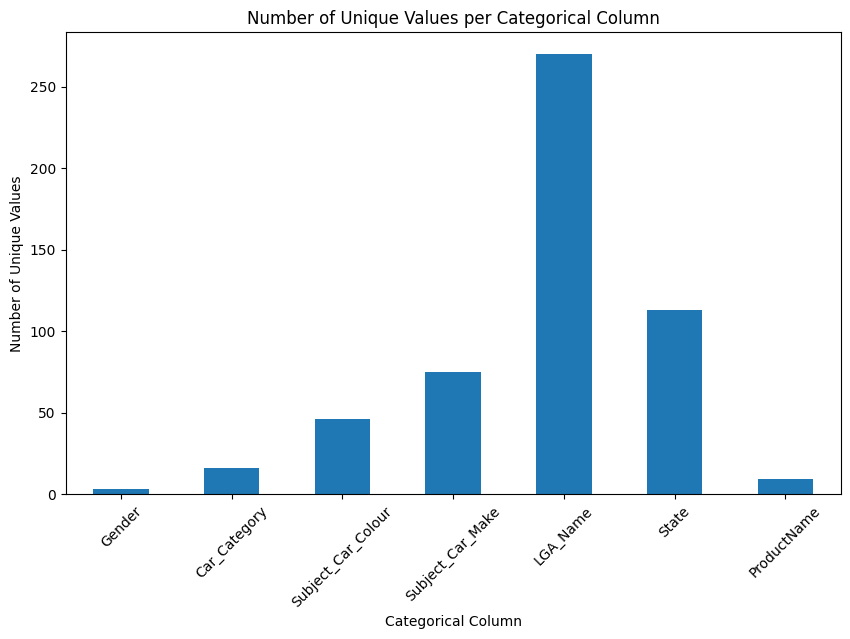

In [ ]:

# Select the categorical columns
categorical_columns = ['Gender', 'Car_Category', 'Subject_Car_Colour', 'Subject_Car_Make', 'LGA_Name', 'State', 'ProductName']

# Calculate the number of unique values for each column
unique_value_counts = all_data[categorical_columns].nunique()

# Plot the number of unique values
plt.figure(figsize=(10, 6))
unique_value_counts.plot(kind='bar')
plt.title('Number of Unique Values per Categorical Column')
plt.xlabel('Categorical Column')
plt.ylabel('Number of Unique Values')
plt.xticks(rotation=45)
plt.show()


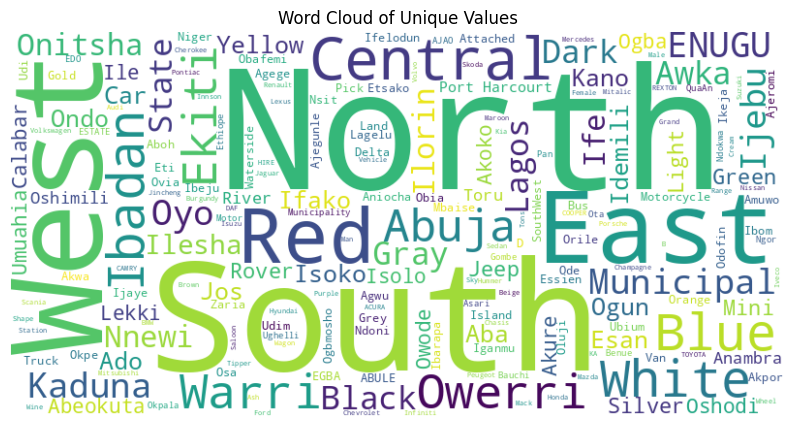

In [ ]:
from wordcloud import WordCloud

# Select the categorical columns
categorical_columns = ['Gender', 'Car_Category', 'Subject_Car_Colour', 'Subject_Car_Make', 'LGA_Name', 'State', 'ProductName']

# Create a list to store the unique values
unique_values = []

# Iterate over each categorical column and extract unique values
for column in categorical_columns:
    unique_values.extend(all_data[column].dropna().unique())

# Join the unique values into a single string
text = ' '.join(unique_values)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Unique Values')
plt.show()


In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13281 entries, 0 to 13280
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID                      13281 non-null  object        
 1   Policy Start Date       13281 non-null  datetime64[ns]
 2   Policy End Date         13281 non-null  datetime64[ns]
 3   Gender                  12881 non-null  category      
 4   Age                     13281 non-null  int64         
 5   First Transaction Date  13281 non-null  datetime64[ns]
 6   No_Pol                  13281 non-null  int64         
 7   Car_Category            9171 non-null   category      
 8   Subject_Car_Colour      5622 non-null   category      
 9   Subject_Car_Make        10557 non-null  category      
 10  LGA_Name                6149 non-null   category      
 11  State                   6137 non-null   category      
 12  ProductName             13281 non-null  catego

### Filling in missing values
#### Missing values can be filled using different strategies
Tips:
 - Mean
 - Max
 - Min
 - [sklearn SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)
 - Others... do more reasearch

In [ ]:
# Fill missing values in categorical columns with mode
categorical_cols = ['Gender', 'Car_Category', 'Subject_Car_Colour', 'Subject_Car_Make', 'LGA_Name', 'State','ProductName']
all_data[categorical_cols] = all_data[categorical_cols].fillna(all_data[categorical_cols].mode().iloc[0])

# Fill missing values in numeric columns with mean
numeric_cols = ['Age', 'No_Pol']
all_data[numeric_cols] = all_data[numeric_cols].fillna(all_data[numeric_cols].mean())

# Check the updated DataFrame
print(all_data)


               ID Policy Start Date Policy End Date  Gender  Age  \
0      ID_0040R73        2010-05-14      2011-05-13    Male   30   
1      ID_0046BNK        2010-11-29      2011-11-28  Female   79   
2      ID_005QMC3        2010-03-21      2011-03-20    Male   43   
3      ID_0079OHW        2010-08-21      2011-08-20    Male    2   
4      ID_00BRP63        2010-08-29      2010-12-31   Other   20   
...           ...               ...             ...     ...  ...   
13276  ID_ZTTHC5X        2010-12-05      2011-12-04    Male   67   
13277  ID_ZUJAFUP        2010-01-14      2011-01-13    Male   43   
13278  ID_ZWHCTUM        2010-07-26      2011-07-25    Male   30   
13279  ID_ZWQRL8L        2010-02-16      2011-02-15    Male   44   
13280  ID_ZWZ92GU        2010-03-18      2011-03-17    Male   28   

      First Transaction Date  No_Pol Car_Category Subject_Car_Colour  \
0                 2010-05-14       1       Saloon              Black   
1                 2010-11-29       1   

In [ ]:
df_filled = all_data

In [ ]:
df_filled.isna().sum()

ID                           0
Policy Start Date            0
Policy End Date              0
Gender                       0
Age                          0
First Transaction Date       0
No_Pol                       0
Car_Category                 0
Subject_Car_Colour           0
Subject_Car_Make             0
LGA_Name                     0
State                        0
ProductName                  0
target                    1202
dtype: int64

### Feature Engineering
#### Alot of features can be extracted from dates
Tips:
 - Quarter, Start of Year, month?
 - Is it a weekend, weekday?
 - Is it a holiday
 - Duration between different periods, e.g start and end of a policy
 - What features can be derived from the age column
 - Be creative 😉

In [ ]:
df_filled['PolicyDuration'] = (df_filled['Policy End Date'] - df_filled['Policy Start Date']).dt.days


In [ ]:
df_filled['PolicyStartYear'] = df_filled['Policy Start Date'].dt.year
df_filled['PolicyEndYear'] = df_filled['Policy End Date'].dt.year


In [ ]:
df_filled['PolicyStartQuarter'] = df_filled['Policy Start Date'].dt.quarter
df_filled['PolicyEndQuarter'] = df_filled['Policy End Date'].dt.quarter


In [ ]:
df_filled['PolicyStartMonth'] = df_filled['Policy Start Date'].dt.month
df_filled['PolicyEndMonth'] = df_filled['Policy End Date'].dt.month


In [ ]:
df_filled

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,...,State,ProductName,target,PolicyDuration,PolicyStartYear,PolicyEndYear,PolicyStartQuarter,PolicyEndQuarter,PolicyStartMonth,PolicyEndMonth
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,...,Lagos,Car Classic,0.0,364,2010,2011,2,2,5,5
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,...,Lagos,Car Classic,1.0,364,2010,2011,4,4,11,11
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,...,Lagos,Car Classic,0.0,364,2010,2011,1,1,3,3
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,Saloon,Black,TOYOTA,...,Lagos,CarSafe,0.0,364,2010,2011,3,3,8,8
4,ID_00BRP63,2010-08-29,2010-12-31,Other,20,2010-08-29,3,Saloon,Black,TOYOTA,...,Lagos,Muuve,1.0,124,2010,2010,3,4,8,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13276,ID_ZTTHC5X,2010-12-05,2011-12-04,Male,67,2010-12-05,2,JEEP,Black,TOYOTA,...,Lagos,Car Classic,NaN,364,2010,2011,4,4,12,12
13277,ID_ZUJAFUP,2010-01-14,2011-01-13,Male,43,2010-01-14,1,Saloon,Silver,Hyundai,...,Lagos,Car Classic,NaN,364,2010,2011,1,1,1,1
13278,ID_ZWHCTUM,2010-07-26,2011-07-25,Male,30,2010-07-26,1,Truck,White,Iveco,...,Lagos,CVTP,NaN,364,2010,2011,3,3,7,7
13279,ID_ZWQRL8L,2010-02-16,2011-02-15,Male,44,2010-02-16,2,Saloon,Black,Nissan,...,Aba-North,Car Classic,NaN,364,2010,2011,1,1,2,2


#### Try different strategies of dealing with categorical variables
Tips:
 - One hot encoding
 - Label encoding
 - Target encoding
 - Reduce the number of unique values...

In [ ]:
df_filled.dtypes

ID                                object
Policy Start Date         datetime64[ns]
Policy End Date           datetime64[ns]
Gender                          category
Age                                int64
First Transaction Date    datetime64[ns]
No_Pol                             int64
Car_Category                    category
Subject_Car_Colour              category
Subject_Car_Make                category
LGA_Name                        category
State                           category
ProductName                     category
target                           float64
PolicyDuration                     int64
PolicyStartYear                    int64
PolicyEndYear                      int64
PolicyStartQuarter                 int64
PolicyEndQuarter                   int64
PolicyStartMonth                   int64
PolicyEndMonth                     int64
dtype: object

In [ ]:
categorical_cols = ['Gender', 'Car_Category', 'Subject_Car_Colour', 'Subject_Car_Make', 'LGA_Name', 'State','ProductName']


In [ ]:
# Encode categorical features
all_data_encoded = pd.get_dummies(data = df_filled, columns = categorical_cols)
all_data_encoded.head()

,ID,Policy Start Date,Policy End Date,Age,First Transaction Date,No_Pol,target,PolicyDuration,PolicyStartYear,PolicyEndYear,...,State_Warri-South,ProductName_CVTP,ProductName_Car Classic,ProductName_Car Plus,ProductName_Car Vintage,ProductName_CarFlex,ProductName_CarSafe,ProductName_Customized Motor,ProductName_Motor Cycle,ProductName_Muuve
0,ID_0040R73,2010-05-14,2011-05-13,30,2010-05-14,1,0.0,364,2010,2011,...,0,0,1,0,0,0,0,0,0,0
1,ID_0046BNK,2010-11-29,2011-11-28,79,2010-11-29,1,1.0,364,2010,2011,...,0,0,1,0,0,0,0,0,0,0
2,ID_005QMC3,2010-03-21,2011-03-20,43,2010-03-21,1,0.0,364,2010,2011,...,0,0,1,0,0,0,0,0,0,0
3,ID_0079OHW,2010-08-21,2011-08-20,2,2010-08-21,1,0.0,364,2010,2011,...,0,0,0,0,0,0,1,0,0,0
4,ID_00BRP63,2010-08-29,2010-12-31,20,2010-08-29,3,1.0,124,2010,2010,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
all_data_encoded.isna().sum()

ID                              0
Policy Start Date               0
Policy End Date                 0
Age                             0
First Transaction Date          0
                               ..
ProductName_CarFlex             0
ProductName_CarSafe             0
ProductName_Customized Motor    0
ProductName_Motor Cycle         0
ProductName_Muuve               0
Length: 546, dtype: int64

In [ ]:
all_data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13281 entries, 0 to 13280
Columns: 546 entries, ID to ProductName_Muuve
dtypes: datetime64[ns](3), float64(1), int64(9), object(1), uint8(532)
memory usage: 8.2+ MB


In [ ]:
# Separate train and test data from the combined dataframe
train_df = all_data_encoded[:ntrain]
test_df = all_data_encoded[ntrain:]

# Check the shapes of the split dataset
train_df.shape, test_df.shape

((12079, 546), (1202, 546))

In [ ]:
train_df

,ID,Policy Start Date,Policy End Date,Age,First Transaction Date,No_Pol,target,PolicyDuration,PolicyStartYear,PolicyEndYear,...,State_Warri-South,ProductName_CVTP,ProductName_Car Classic,ProductName_Car Plus,ProductName_Car Vintage,ProductName_CarFlex,ProductName_CarSafe,ProductName_Customized Motor,ProductName_Motor Cycle,ProductName_Muuve
0,ID_0040R73,2010-05-14,2011-05-13,30,2010-05-14,1,0.0,364,2010,2011,...,0,0,1,0,0,0,0,0,0,0
1,ID_0046BNK,2010-11-29,2011-11-28,79,2010-11-29,1,1.0,364,2010,2011,...,0,0,1,0,0,0,0,0,0,0
2,ID_005QMC3,2010-03-21,2011-03-20,43,2010-03-21,1,0.0,364,2010,2011,...,0,0,1,0,0,0,0,0,0,0
3,ID_0079OHW,2010-08-21,2011-08-20,2,2010-08-21,1,0.0,364,2010,2011,...,0,0,0,0,0,0,1,0,0,0
4,ID_00BRP63,2010-08-29,2010-12-31,20,2010-08-29,3,1.0,124,2010,2010,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12074,ID_ZZA1SES,2010-05-25,2011-05-24,30,2010-05-25,1,1.0,364,2010,2011,...,0,0,1,0,0,0,0,0,0,0
12075,ID_ZZDAC3K,2010-10-03,2011-10-02,59,2010-10-03,1,0.0,364,2010,2011,...,0,0,1,0,0,0,0,0,0,0
12076,ID_ZZIU2XC,2010-10-10,2011-10-08,34,2010-10-10,1,0.0,363,2010,2011,...,0,0,0,0,0,0,1,0,0,0
12077,ID_ZZRQ1NF,2010-02-27,2011-02-26,120,2010-02-27,2,0.0,364,2010,2011,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
test_df

,ID,Policy Start Date,Policy End Date,Age,First Transaction Date,No_Pol,target,PolicyDuration,PolicyStartYear,PolicyEndYear,...,State_Warri-South,ProductName_CVTP,ProductName_Car Classic,ProductName_Car Plus,ProductName_Car Vintage,ProductName_CarFlex,ProductName_CarSafe,ProductName_Customized Motor,ProductName_Motor Cycle,ProductName_Muuve
12079,ID_01QM0NU,2010-10-23,2011-10-22,46,2010-10-23,1,NaN,364,2010,2011,...,0,0,1,0,0,0,0,0,0,0
12080,ID_024NJLZ,2010-10-14,2011-10-13,32,2010-10-14,1,NaN,364,2010,2011,...,0,0,1,0,0,0,0,0,0,0
12081,ID_02NOVWQ,2010-08-29,2011-08-28,45,2010-08-29,2,NaN,364,2010,2011,...,0,0,1,0,0,0,0,0,0,0
12082,ID_02VSP68,2010-06-13,2011-06-12,58,2010-06-13,1,NaN,364,2010,2011,...,0,0,0,0,0,0,1,0,0,0
12083,ID_02YB37K,2010-07-01,2011-06-30,120,2010-07-01,1,NaN,364,2010,2011,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13276,ID_ZTTHC5X,2010-12-05,2011-12-04,67,2010-12-05,2,NaN,364,2010,2011,...,0,0,1,0,0,0,0,0,0,0
13277,ID_ZUJAFUP,2010-01-14,2011-01-13,43,2010-01-14,1,NaN,364,2010,2011,...,0,0,1,0,0,0,0,0,0,0
13278,ID_ZWHCTUM,2010-07-26,2011-07-25,30,2010-07-26,1,NaN,364,2010,2011,...,0,1,0,0,0,0,0,0,0,0
13279,ID_ZWQRL8L,2010-02-16,2011-02-15,44,2010-02-16,2,NaN,364,2010,2011,...,0,0,1,0,0,0,0,0,0,0


### Training and making predictions
Tips:
- Is lgbm the best model for this challenge?
- Parameter tuning
 - Grid search, random search, perhaps bayesian search works better...



#### [More on F1 Score](https://en.wikipedia.org/wiki/F-score)

### Making predictions of the test set and creating a submission file

In [ ]:
# Select main columns to be used in training
main_cols = all_data_encoded.columns.difference(date_cols+['ID', 'target'])
X = train_df[main_cols]
y = train_df.target

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)


In [ ]:
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.metrics import f1_score, make_scorer, classification_report, confusion_matrix
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Define the classifiers to evaluate
classifiers = [
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    XGBClassifier(),
    LGBMClassifier()
]

# Define the hyperparameter grids for each classifier
param_grids = [
    {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [None, 5, 10],
        'classifier__class_weight': ['balanced', None]
    },
]


# Perform cross-validation with hyperparameter tuning for each classifier
for classifier, param_grid in zip(classifiers, param_grids):
    # Define the pipeline with SMOTE oversampling
    pipeline = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('classifier', classifier)
    ])

    # Perform RandomizedSearchCV for hyperparameter tuning
    random_search = RandomizedSearchCV(pipeline, param_grid, scoring='f1', cv=5, n_iter=10, random_state=42)
    random_search.fit(X_train, y_train)

    # Get the best estimator and evaluate on the test set
    best_estimator = random_search.best_estimator_
    y_pred = best_estimator.predict(X_test)

    # Calculate evaluation metrics
    f1 = f1_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Print the results
    print(f"Classifier: {classifier.__class__.__name__}")
    print(f"F1 Score: {f1}")
    print("Classification Report:")
    print(report)
    print("Confusion Matrix:")
    print(cm)
    print("==============================")


Classifier: RandomForestClassifier
F1 Score: 0.3635077793493635
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.77      0.85      3184
         1.0       0.26      0.58      0.36       440

    accuracy                           0.75      3624
   macro avg       0.60      0.68      0.60      3624
weighted avg       0.85      0.75      0.79      3624

Confusion Matrix:
[[2467  717]
 [ 183  257]]


In [ ]:
test_df

,ID,Policy Start Date,Policy End Date,Age,First Transaction Date,No_Pol,target,PolicyDuration,PolicyStartYear,PolicyEndYear,...,State_Warri-South,ProductName_CVTP,ProductName_Car Classic,ProductName_Car Plus,ProductName_Car Vintage,ProductName_CarFlex,ProductName_CarSafe,ProductName_Customized Motor,ProductName_Motor Cycle,ProductName_Muuve
12079,ID_01QM0NU,2010-10-23,2011-10-22,46,2010-10-23,1,NaN,364,2010,2011,...,0,0,1,0,0,0,0,0,0,0
12080,ID_024NJLZ,2010-10-14,2011-10-13,32,2010-10-14,1,NaN,364,2010,2011,...,0,0,1,0,0,0,0,0,0,0
12081,ID_02NOVWQ,2010-08-29,2011-08-28,45,2010-08-29,2,NaN,364,2010,2011,...,0,0,1,0,0,0,0,0,0,0
12082,ID_02VSP68,2010-06-13,2011-06-12,58,2010-06-13,1,NaN,364,2010,2011,...,0,0,0,0,0,0,1,0,0,0
12083,ID_02YB37K,2010-07-01,2011-06-30,120,2010-07-01,1,NaN,364,2010,2011,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13276,ID_ZTTHC5X,2010-12-05,2011-12-04,67,2010-12-05,2,NaN,364,2010,2011,...,0,0,1,0,0,0,0,0,0,0
13277,ID_ZUJAFUP,2010-01-14,2011-01-13,43,2010-01-14,1,NaN,364,2010,2011,...,0,0,1,0,0,0,0,0,0,0
13278,ID_ZWHCTUM,2010-07-26,2011-07-25,30,2010-07-26,1,NaN,364,2010,2011,...,0,1,0,0,0,0,0,0,0,0
13279,ID_ZWQRL8L,2010-02-16,2011-02-15,44,2010-02-16,2,NaN,364,2010,2011,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
# Make prediction on the test set
test_df = test_df[main_cols]
predictions = best_estimator.predict(test_df)

# Create a submission file
sub_file = ss.copy()
predictions
predictions = pd.DataFrame(predictions)
sub_file.target = predictions
sub_file.to_csv("submission.csv")